# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [67]:
import io
import os
import numpy as np
import scipy

In [68]:
PATH_TO_DATA = "./data"

# 1) Monolingual (English) word embeddings 

In [69]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        cosine_sim_list = []
        sim_words = []
        count = 0
        
        for key in self.word2vec.keys():
            self.word2id[key]=count
            count=count+1
            
        self.id2word = {v: k for k, v in self.word2id.items()}
        
        #Computing Scores
        for word in self.word2vec.keys():
            cosine_sim_list.append(self.score(w,word))
        
        #Sorting and extracting top k nearest neighbors
        cosine_sim_mat = np.array(cosine_sim_list)
        sorted_id = np.argsort(cosine_sim_mat)
        sorted_id = sorted_id[::-1][0:K]
        
        #Get Names from IDs
        for id in sorted_id:
            sim_words.append(self.id2word[id])
            
        return sim_words
        

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        
        w1_embedding = self.word2vec[w1]
        w2_embedding = self.word2vec[w2]
              
        cosine_similarity_score = np.dot(w1_embedding, w2_embedding) / (np.linalg.norm(w1_embedding) * np.linalg.norm(w2_embedding))
        return cosine_similarity_score

In [70]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000) 

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))
    
#Note: After discussing with one of the course TA, I changed nmax from 25000 to 100000 to incorporate words 
#like france, germany.

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288558
germany berlin 0.7420295235998394
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
['paris', 'france', 'Paris', 'london', 'berlin']
['germany', 'austria', 'europe', 'german', 'berlin']


In [71]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        idf_dic = idf
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                list_embeddings = [self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(list_embeddings)==0: #if any word in the sentence is in our lookup table
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                else:
                    sentemb.append(np.mean(list_embeddings, axis=0))
            else:
                # idf-weighted mean of word vectors
                list_embeddings = [idf_dic[w]*self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(list_embeddings)==0: #if any word in the sentence is in our lookup table
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                else:
                    sentemb.append(np.mean(list_embeddings, axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        #keys = self.encode(sentences, idf)
        #query = self.encode([s], idf)
        list_score = [self.score(s,key_sent,idf) for key_sent in sentences]
        index_best_sent = (np.argsort(list_score)[::-1][:K])
        all_sent = []
        print('Top-%s Nearest Neighbours of the sentence \n"%s"\n\n' % (K, ' '.join(s)))
        if max(list_score)>0:
            for i,ind_best in enumerate(index_best_sent):
                print('%s) %s' % (i + 1, ' '.join(sentences[ind_best])))
                all_sent.append(sentences[ind_best])
        else: #empty sentence or sentence with unknown words
            print('The input sentence does not contains words that are present in the loaded embedding')
        return all_sent

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        emb2 = self.encode([s2], idf)
        emb1 = self.encode([s1], idf)
        if ((np.linalg.norm(emb1)!=0) and ((np.linalg.norm(emb2)!=0))):
            return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        else: #if an embedding as a zero vector
            return 0
                                           
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1        
        for w in idf:
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf

In [72]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"

with open(os.path.join(PATH_TO_DATA,'sentences.txt')) as f:
    sentences = f.readlines()

sentences = [sent.split() for sent in sentences]
# Build idf scores for each word
idf = {} if False else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))
print('\n----\n')

s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors
Top-5 Nearest Neighbours of the sentence 
"1 smiling african american boy ."


1) 1 smiling african american boy .
2) blond boy waterskiing .
3) a boy jumps .
4) a boy jumps .
5) a boy smiles underwater .
[[0.60894451]]

----

Top-5 Nearest Neighbours of the sentence 
"1 smiling african american boy ."


1) 1 smiling african american boy .
2) 5 women and 1 man are smiling for the camera .
3) a man rides a 4 wheeler in the desert .
4) 3 males and 1 woman enjoying a sporting event
5) a man in black is juggling 3 flamed bottles .
[[0.59633357]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [73]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
print("Loading the English Word Embeddings")
word2vec_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
print("Loading the French Word Embeddings")
word2vec_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

# Patching id2word
for i, key in enumerate(word2vec_fr.word2vec.keys()):
    word2vec_fr.word2id[key]=i    
word2vec_fr.id2word = {v: k for k, v in word2vec_fr.word2id.items()}

for i, key in enumerate(word2vec_en.word2vec.keys()):
    word2vec_en.word2id[key]=i    
word2vec_en.id2word = {v: k for k, v in word2vec_en.word2id.items()}

Loading the English Word Embeddings
Loaded 50000 pretrained word vectors
Loading the French Word Embeddings
Loaded 50000 pretrained word vectors


In [74]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

shared_words = []
for word in word2vec_en.word2vec:
    if word in word2vec_fr.word2vec:
        shared_words.append(word)

print("Number of words in the Shared Vocabulary", len(shared_words))

X = []
Y = []
for word in shared_words:
    X.append(word2vec_en.word2vec[word])
    Y.append(word2vec_fr.word2vec[word])
    
X = np.array(X).T
Y = np.array(Y).T

print("X shape : ", X.shape)
print("Y shape : ", X.shape)

Number of words in the Shared Vocabulary 18970
X shape :  (300, 18970)
Y shape :  (300, 18970)


In [76]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

from scipy import linalg
U, S, V = linalg.svd(np.dot(Y, X.T))
W = np.dot(U, V)
word2vec_fr_aligned_to_en = np.dot(list(word2vec_fr.word2vec.values()), W)

id2word_fr_aligned_to_en = dict()
id2word_fr_list_aligned_to_en = list(word2vec_fr.word2vec)

for id_word in range(len(word2vec_fr_aligned_to_en)):
    id2word_fr_aligned_to_en[id2word_fr_list_aligned_to_en[id_word]] = word2vec_fr_aligned_to_en[id_word]

print("U shape", U.shape)
print("W shape", W.shape)
print("word2vec_fr_aligned_to_en space shape", word2vec_fr_aligned_to_en.shape)

U shape (300, 300)
W shape (300, 300)
word2vec_fr_aligned_to_en space shape (50000, 300)


In [77]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

def score(word_vec, word_vec_candidate):
    return np.dot(word_vec, word_vec_candidate)/(np.linalg.norm(word_vec)*np.linalg.norm(word_vec_candidate))

def translate_fr2en(word_to_translate, K = 5):
    if word_to_translate not in id2word_fr_aligned_to_en:
        raise ValueError("Word not in dic")
    
    # Get scores
    scores = {}
    word_vec = id2word_fr_aligned_to_en[word_to_translate]
    for word in word2vec_en.word2vec:
        word_vec_candidate = word2vec_en.word2vec[word]
        scores[word] = score(word_vec, word_vec_candidate)
    return sorted(scores, key=scores.get)[::-1][0:K]

print('\nTranslating French Into English\n')

fr = ["oiseau", "chat", "souris", "voiture", "vacances"]
for word in fr:
    print(word, ":", translate_fr2en(word))

        
def translate_en2fr(word_to_translate, K = 5):
    if word_to_translate not in word2vec_en.word2vec:
        raise ValueError("Word not in dic")
    
    # Get scores
    scores = {}
    word_vec = word2vec_en.word2vec[word_to_translate]
    for word in id2word_fr_aligned_to_en:
        word_vec_candidate = np.array(id2word_fr_aligned_to_en[word])
        scores[word] = score(word_vec, word_vec_candidate)
    return sorted(scores, key=scores.get)[::-1][0:K]

print("\n Translating English Into French \n")

en = ["actress", "phone", "elevator", "king", "kitchen"]
for word in en:
    print(word, ":", translate_en2fr(word))


Translating French Into English

oiseau : ['bird', 'birds', 'flightless', 'owl', 'passerine']
chat : ['cat', 'rabbit', 'hamster', 'feline', 'poodle']
souris : ['mouse', 'mice', 'rats', 'rodents', 'raccoons']
voiture : ['car', 'cars', 'limousine', 'suv', 'roadster']
vacances : ['vacation', 'vacations', 'holiday', 'holidays', 'honeymoon']

 Translating English Into French 

actress : ['actrice', 'comédienne', 'actrices', 'réalisatrice', 'actress']
phone : ['téléphone', 'téléphones', 'téléphonie', 'téléphonique', 'phone']
elevator : ['ascenseur', 'ascenseurs', 'cabine', 'hangar', 'escaliers']
king : ['roi', 'king', 'rois', 'reine', 'trône']
kitchen : ['cuisines', 'cuisine', 'room', 'kitchen', 'cuisiner']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [79]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def read_training_data(file_path):
    #This function allows to read the SST training file
    with open(file_path,'r') as f:
        lines = f.readlines()
    y_train= [int(line[0]) for line in lines] 
    x_train= [line[2:].split() for line in lines]
    return x_train,y_train

def read_test_data(file_path):
    #This function allows to read the SST test file
    with open(file_path,'r') as f:
        lines = f.readlines()
    x_test = [line.split() for line in lines]
    return x_test

sst_train_data, sst_train_label = read_training_data(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
sst_dev_data, sst_dev_label = read_training_data(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
sst_test_data = read_test_data(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'))

#print(len(sst_train_data))
#print(len(sst_dev_data))
#print(len(sst_test_data))

In [80]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)

idf = {} if False else s2v.build_idf(sst_train_data+sst_dev_data+sst_test_data)

train_sentemb = s2v.encode(sst_train_data)
train_sentemb_idf = s2v.encode(sst_train_data,idf)

dev_sentemb = s2v.encode(sst_dev_data)
dev_sentemb_idf = s2v.encode(sst_dev_data,idf)

test_sentemb = s2v.encode(sst_test_data)
test_sentemb_idf = s2v.encode(sst_test_data,idf)

Loaded 25000 pretrained word vectors


In [81]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#print(train_sentemb.shape)
#print(dev_sentemb.shape)
#print(test_sentemb.shape)

min_max_scaler = MinMaxScaler()
train_features = min_max_scaler.fit_transform(train_sentemb)
dev_features = min_max_scaler.transform(dev_sentemb)
test_features = min_max_scaler.transform(test_sentemb)

min_max_scaler = MinMaxScaler()
train_features_idf = min_max_scaler.fit_transform(train_sentemb_idf)
dev_features_idf = min_max_scaler.transform(dev_sentemb_idf)
test_features_idf = min_max_scaler.transform(test_sentemb_idf)

#Training the classifier without IDF
classifier = LogisticRegression(solver='lbfgs',max_iter=1000,penalty='l2')
classifier = classifier.fit(train_features,sst_train_label)

#Testing the classifier on Train Data
y_train_pred = classifier.predict(train_features)
acc = accuracy_score(sst_train_label,y_train_pred,normalize=True)
print('The accuracy achieved by the Logistic Regression Classifier Model (without IDF features) on Train Set is: ', acc)

# Testing the classifier on Dev Data
y_dev_pred = classifier.predict(dev_features)
#Compute Accuracy Score
acc = accuracy_score(sst_dev_label,y_dev_pred,normalize=True)
print('The accuracy achieved by the Logistic Regression Classifier Model (without IDF features) on Dev Set is: ', acc)
    
#-------------------------------------------------IDF Features--------------------------------------

#Training the classifier with idf features
classifier_idf = LogisticRegression(solver='lbfgs',max_iter=1000,penalty='l2')
classifier_idf = classifier.fit(train_features_idf,sst_train_label)

#Testing the classifier on Train Data
y_train_pred_idf = classifier.predict(train_features_idf)
acc = accuracy_score(sst_train_label,y_train_pred_idf,normalize=True)
print('The accuracy achieved by the Logistic Regression Classifier Model (with IDF features) on Train Set is: ', acc)

# Testing the classifier on Dev Data
y_dev_pred_idf = classifier.predict(dev_features_idf)

#Compute Accuracy Score
acc = accuracy_score(sst_dev_label,y_dev_pred_idf,normalize=True)
print('The accuracy achieved by the Logistic Regression Classifier Model (with IDF features) on Dev Set is: ', acc)

The accuracy achieved by the Logistic Regression Classifier Model (without IDF features) on Train Set is:  0.4774110486891386
The accuracy achieved by the Logistic Regression Classifier Model (without IDF features) on Dev Set is:  0.4069028156221617
The accuracy achieved by the Logistic Regression Classifier Model (with IDF features) on Train Set is:  0.4637172284644195
The accuracy achieved by the Logistic Regression Classifier Model (with IDF features) on Dev Set is:  0.3941871026339691


In [82]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
y_test_pred = classifier.predict(test_features)
np.savetxt("logreg_bov_y_test_sst.txt", y_test_pred,fmt='%s')

In [83]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

#-------------Using Gradient Boosting Classifier from LGBM Library---------------------------------

from lightgbm import LGBMClassifier
lgb_classifier = LGBMClassifier(max_depth=5,n_estimators=5000,reg_lambda=2)
lgb_classifier.fit(train_features,sst_train_label,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(train_features_idf,sst_train_label),(dev_features_idf,sst_dev_label)])

y_dev_pred_values = lgb_classifier.predict(dev_features)
acc = accuracy_score(sst_dev_label,y_dev_pred_values,normalize=True)
print('The accuracy achieved by the Gradient Boosting Model from LGBM Library on Dev Set is: ', acc)

y_test_pred = lgb_classifier.predict(test_features)
#print(y_test_pred.shape)
np.savetxt("lgbm_gradientboosting_bov_y_test_sst.txt", y_test_pred,fmt='%s')

The accuracy achieved by the Gradient Boosting Model from LGBM Library on Dev Set is:  0.4087193460490463


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [93]:
import keras

In [94]:
# 1 - Load train/dev/test sets of SST
# TYPE CODE HERE
PATH_TO_DATA = "./data/"

x_train,y_train = read_training_data(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
x_dev,y_dev = read_training_data(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
x_test = read_test_data(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'))

In [95]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text
from keras.utils import to_categorical

list_w = set([w for sent in (x_train+x_dev+x_test) for w in sent ])
num_words = len(list_w)


x_train_one_hot = [text.one_hot(' '.join(x),num_words) for x in x_train]
x_dev_one_hot = [text.one_hot(' '.join(x),num_words) for x in x_dev]
x_test_one_hot = [text.one_hot(' '.join(x),num_words) for x in x_test]


y_train = to_categorical(y_train)
y_val = to_categorical(y_dev)
#print(y_train.shape)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [96]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences


x_train_pad = pad_sequences(x_train_one_hot, maxlen=20)
x_val_pad = pad_sequences(x_dev_one_hot, maxlen=20)
x_test_pad = pad_sequences(x_test_one_hot,maxlen=20)

## 4.2 - Design and train your model

In [97]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 20  # word embedding dimension
nhid       = 8  # number of hidden units in the LSTM
vocab_size = num_words  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(n_classes, activation='softmax'))

In [98]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, None, 20)          390720    
_________________________________________________________________
lstm_36 (LSTM)               (None, 8)                 928       
_________________________________________________________________
dense_69 (Dense)             (None, 5)                 45        
Total params: 391,693
Trainable params: 391,693
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 22s 3ms/step - loss: 1.5745 - acc: 0.2726 - val_loss: 1.5670 - val_acc: 0.3134
Epoch 2/10
8544/8544 [==============================] - 13s 2ms/step - loss: 1.5490 - acc: 0.3123 - val_loss: 1.5294 - val_acc: 0.3270
Epoch 3/10
8544/8544 [==============================] - 12s 1ms/step - loss: 1.4946 - acc: 0.3530 - val_loss: 1.4770 - val_acc: 0.3497
Epoch 4/10
8544/8544 [==============================] - 12s 1ms/step - loss: 1.4305 - acc: 0.3796 - val_loss: 1.4408 - val_acc: 0.3778
Epoch 5/10
8544/8544 [==============================] - 13s 1ms/step - loss: 1.3633 - acc: 0.4120 - val_loss: 1.4243 - val_acc: 0.3778
Epoch 6/10
8544/8544 [==============================] - 12s 1ms/step - loss: 1.3047 - acc: 0.4439 - val_loss: 1.4109 - val_acc: 0.4033
Epoch 7/10
8544/8544 [==============================] - 13s 2ms/step - loss: 1.2614 - acc: 0.4631 - val_loss: 1.4062 - val_acc: 0.3996
Epoch 8

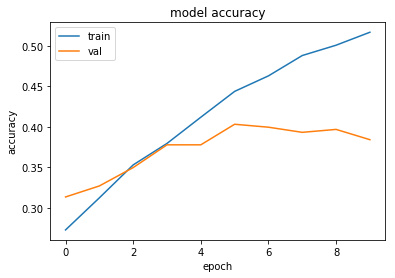

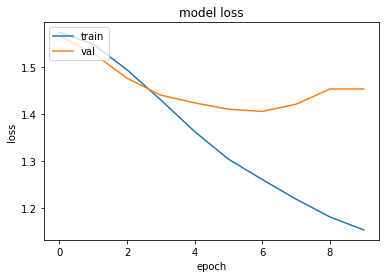

In [99]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
import matplotlib.pyplot as plt
%matplotlib inline

bs = 8
n_epochs = 10

# For early stopping
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
history = model.fit(x_train_pad, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val_pad, y_val),shuffle=True,callbacks=[estop])

plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
plt.savefig('Accuracy_Plot_LSTM')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
plt.savefig('Loss_Plot_LSTM')

In [100]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_test_pred = model.predict(x_test_pad)
#print(y_test_pred.shape)
#print y_test_pred
y_test_pred = np.argmax(y_test_pred, axis=1)
#print y_test_pred.shape
np.savetxt("logreg_lstm_y_test_sst.txt", y_test_pred,fmt='%s')

## 4.3 -- innovate !

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 20, 20)            390720    
_________________________________________________________________
dropout_78 (Dropout)         (None, 20, 20)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 14, 32)            4512      
_________________________________________________________________
global_max_pooling1d_49 (Glo (None, 32)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 10)                330       
_________________________________________________________________
dropout_79 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 5)                 55        
Total para

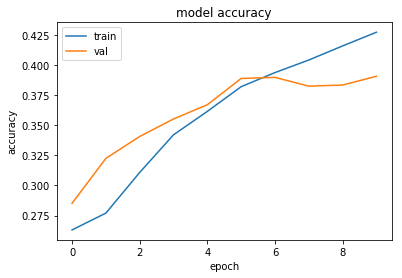

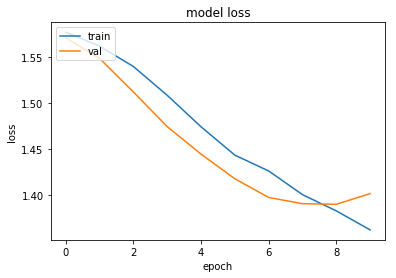

In [105]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, GlobalMaxPooling1D, Conv1D, Bidirectional
from keras.layers import Dense, Embedding, Dropout, LSTM
from keras.layers.normalization import BatchNormalization



embed_dim  = 20  # word embedding dimension
nhid       = 8  # number of hidden units in the LSTM
vocab_size = num_words  # size of the vocabulary
n_classes  = 5
n_epochs = 10
bs = 8

new_model = Sequential()
new_model.add(Embedding(vocab_size, embed_dim,input_length=20))
new_model.add(Dropout(0.5))
new_model.add(Conv1D(32, 7, activation='relu'))
new_model.add(GlobalMaxPooling1D())
new_model.add(Dense(10, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(n_classes, activation='softmax'))

new_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
new_model.summary()

estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
history = new_model.fit(x_train_pad, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val_pad, y_val),callbacks=[estop])

plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Accuracy_Plot_Conv1D')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Loss_Plot_Conv1D')

y_test_pred = model.predict(x_test_pad)
#print y_test_pred.shape
##print y_test_pred
y_test_pred = np.argmax(y_test_pred, axis=1)
#print y_test_pred.shape
np.savetxt("conv1D_bilstm_y_test_sst.txt", y_test_pred,fmt='%s')